In [605]:
import numpy as np
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, product
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import random
import matplotlib.pyplot as plt
import scipy.sparse as sparse


In [432]:
ped_file = '../../DATA/mssng/mssng.ped.quads.ped'
phase_dir = '../../PhasingFamilies/phased_mssng_quads_common'
identicals_file = '../../PhasingFamilies/sibpair_similarity/mssng_quads_identicals.txt'

#ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'
#phase_dir = '../../PhasingFamilies/phased_ihart.ms2_quads_nopass'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/ihart.ms2_quads_identicals.txt'

#ped_file = '../../DATA/spark.exome/spark.ped.quads.ped'
#phase_dir = '../../PhasingFamilies/phased_spark.exome_quads'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/spark_quads_identicals.txt'

#ped_file = '../../DATA/ssc.hg38/ssc.ped'
#phase_dir = '../../PhasingFamilies/phased_ssc.hg38'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/ssc_identicals.txt'


interval_chrom, interval_start_pos, interval_end_pos = "10", 125067164, 126635114


In [433]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_sex[pieces[3]] = '2'
			sample_to_sex[pieces[2]] = '1'
			sample_to_affected[pieces[1]] = pieces[5]
			parents_to_children[(pieces[0], pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children


Sibpair = namedtuple('Sibpair', ['family', 'sibling1', 'sibling2', 'mom', 'dad', 'phase_dir', 
                                 'num_affected', 'num_males', 
                                 'sibling1_aff', 'sibling2_aff', 'sibling1_male', 'sibling2_male'])
def pull_sibpairs(phase_dir, sample_to_affected, sample_to_sex, parents_to_children, identicals_file):

	# pull identicals
	leave_out = set()
	with open(identicals_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			for sibling1, sibling2 in combinations(pieces, 2):
				leave_out.add((sibling1, sibling2))
				leave_out.add((sibling2, sibling1))


	# pull sibpairs with phase data
	sibpair_has_phase_data = set()
	family_to_inds = dict()
	for filename in listdir(phase_dir):
		if filename.endswith('.phased.txt'):
			family_key = filename[:-11]
			try:
				with open('%s/%s' % (phase_dir, filename), 'r')  as f:
					header = next(f).strip().split('\t')
					individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
					family_to_inds[family_key] = individuals
					for sibling1, sibling2 in combinations(individuals[2:], 2):
						if (sibling1, sibling2) not in leave_out:
							sibpair_has_phase_data.add((sibling1, sibling2))
							sibpair_has_phase_data.add((sibling2, sibling1))
			except StopIteration:
				pass



	def form_sibpair(family, sibling1, sibling2, mom, dad):
		return Sibpair(family, sibling1, sibling2, mom, dad,
			phase_dir,
			int(sample_to_affected[sibling1]=='2')+int(sample_to_affected[sibling2]=='2'),
			int(sample_to_sex[sibling1]=='1')+int(sample_to_sex[sibling2]=='1'),
			sample_to_affected[sibling1]=='2', sample_to_affected[sibling2]=='2',
			sample_to_sex[sibling1]=='1', sample_to_sex[sibling2]=='1')
	# pull sibpairs from families
	sibpairs = []
	for (family, mom, dad), children in parents_to_children.items():
		for sibling1, sibling2 in combinations([x for x in children if x in sample_to_affected], 2):
			if (sibling1, sibling2) in sibpair_has_phase_data:
				sibpairs.append(form_sibpair(family, sibling1, sibling2, mom, dad))
	sibpairs = sorted(sibpairs)

	for i in range(len(sibpairs)-1):
		if sibpairs[i] == sibpairs[i+1]:
			print(sibpairs[i])

	assert len(sibpairs) == len(set(sibpairs)) # should have no duplicates
	return sibpairs, family_to_inds


def pull_intervals(chrom, sibpairs, family_to_inds, interval_start_pos=None, interval_end_pos=None):

	positions = set()
	if interval_start_pos is not None:
		positions.add(interval_start_pos)
	else:
		positions.add(0)
	if interval_end_pos is not None:
		positions.add(interval_end_pos)

	for sibpair_index, sibpair in enumerate(sibpairs):
		inds = family_to_inds[sibpair.family]
		sib1_ind_index, sib2_ind_index = inds.index(sibpair.sibling1), inds.index(sibpair.sibling2)
		sib1_mat_index, sib2_mat_index = 4+2*sib1_ind_index, 4+2*sib2_ind_index
		sib1_pat_index, sib2_pat_index = 5+2*sib1_ind_index, 5+2*sib2_ind_index
		sib_phase_indices = [sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index]
		

		with open('%s/%s.phased.txt' % (sibpair.phase_dir, sibpair.family), 'r')  as f:
			next(f) # skip header

			prev_state = None
			for line in f:
				if line.startswith('chr%s\t'%chrom):
					pieces = line.strip().split('\t')
					
					start_pos, end_pos = [int(x) for x in pieces[-2:]]
					state = np.array([int(x) for x in pieces[1:-2]])

					if prev_state is None or not np.all(state[sib_phase_indices]==prev_state[sib_phase_indices]):
						prev_state = state
						if ((interval_start_pos is None) or start_pos >= interval_start_pos) and ((interval_end_pos is None) or start_pos <= interval_end_pos):
							positions.add(start_pos)
						if ((interval_start_pos is None) or end_pos >= interval_start_pos) and ((interval_end_pos is None) or end_pos <= interval_end_pos):
							positions.add(end_pos)

	return np.array(sorted(positions))

def pull_sibpair_matches(sibpairs, family_to_inds, chroms, interval_bins, interval_chrom=None, interval_start_pos=None, interval_end_pos=None):
	sibpair_to_index = dict([((x.family, x.sibling1, x.sibling2), i) for i, x in enumerate(sibpairs)])
	interval_start_to_index = dict([((chrom, x), i) for i, (chrom, x) in enumerate(zip(chroms, interval_bins[0, :]))])

	# pull phase data
	# sibpair, interval
	#is_mat_match = np.zeros((len(sibpair_to_index), len(interval_bins)-1), dtype=int)
	#is_pat_match = np.zeros((len(sibpair_to_index), len(interval_bins)-1), dtype=int)
	is_mat_match, is_pat_match = [], []

	def update_matches(sibpair_index, chrom, start_pos, end_pos, state, sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index, interval_start_pos, interval_end_pos):
		if interval_start_pos is not None or interval_end_pos is not None:
			start_pos = np.clip(start_pos, interval_start_pos, interval_end_pos)
			end_pos = np.clip(end_pos, interval_start_pos, interval_end_pos)

		start_index, end_index = interval_start_to_index[(chrom, start_pos)], interval_start_to_index[(chrom, end_pos)]
						
		if state[sib1_mat_index]==-1 or state[sib2_mat_index]==-1:
			pass
		elif state[sib1_mat_index]==state[sib2_mat_index]:
			#is_mat_match[sibpair_index, start_index:end_index] = 1
			is_mat_match.append((sibpair_index, start_index, end_index, 1))
		else:
			#is_mat_match[sibpair_index, start_index:end_index] = -1
			is_mat_match.append((sibpair_index, start_index, end_index, -1))
		if state[sib1_pat_index]==-1 or state[sib2_pat_index]==-1:
			pass
		elif state[sib1_pat_index]==state[sib2_pat_index]:
			#is_pat_match[sibpair_index, start_index:end_index] = 1
			is_pat_match.append((sibpair_index, start_index, end_index, 1))
		else:
			#is_pat_match[sibpair_index, start_index:end_index] = -1
			is_pat_match.append((sibpair_index, start_index, end_index, -1))

	for sibpair_index, sibpair in enumerate(sibpairs):
		inds = family_to_inds[sibpair.family]
		sib1_ind_index, sib2_ind_index = inds.index(sibpair.sibling1), inds.index(sibpair.sibling2)
		sib1_mat_index, sib2_mat_index = 4+2*sib1_ind_index, 4+2*sib2_ind_index
		sib1_pat_index, sib2_pat_index = 5+2*sib1_ind_index, 5+2*sib2_ind_index
		sib_phase_indices = [sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index]
		
		with open('%s/%s.phased.txt' % (sibpair.phase_dir, sibpair.family), 'r')  as f:
			next(f) # skip header

			prev_chrom = None
			prev_state = None
			prev_start, prev_end = None, None
			for line in f:
				pieces = line.strip().split('\t')
				
				try:
					chrom = int(pieces[0][3:])
					start_pos, end_pos = [int(x) for x in pieces[-2:]]
					state = np.array([int(x) for x in pieces[1:-2]])


					if (prev_state is None) or (prev_chrom != chrom) or (not np.all(state[sib_phase_indices]==prev_state[sib_phase_indices])):
						# first save prev state
						if prev_state is not None and (interval_chrom is None or interval_chrom==str(prev_chrom)):
							update_matches(sibpair_index, prev_chrom, prev_start, prev_end, prev_state, 
								sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index,
								interval_start_pos, interval_end_pos)
						prev_state = state
						prev_chrom, prev_start, prev_end = chrom, start_pos, end_pos
					else:
						prev_end = end_pos
				except ValueError:
					pass
					

	return is_mat_match, is_pat_match


# pull ped info
sample_to_affected, sample_to_sex, parents_to_children= pull_phenotype_ped(ped_file)

# pull sibpairs
sibpairs, family_to_inds = pull_sibpairs(phase_dir, sample_to_affected, sample_to_sex, parents_to_children, identicals_file)
  
print('Overall')
print('families', len(set([x.family.split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
print('num_affected', Counter([x.num_affected for x in sibpairs]))


chroms, interval_bins_starts, interval_bins_ends = [], [], []
if interval_chrom is not None:
	interval_bins = pull_intervals(interval_chrom, sibpairs, family_to_inds, interval_start_pos, interval_end_pos)
	print(interval_chrom, 'intervals', len(interval_bins))

	chroms.append(int(interval_chrom)*np.ones((interval_bins.shape[0],)))
	interval_bins_starts.append(interval_bins)
	interval_bins_ends.append(np.hstack((interval_bins[1:], [interval_bins[-1]])))
else:
	for chrom in [str(x) for x in range(1, 23)]:
		interval_bins = pull_intervals(chrom, sibpairs, family_to_inds, interval_start_pos, interval_end_pos)
		print(chrom, 'intervals', len(interval_bins))

		
		chroms.append(int(chrom)*np.ones((interval_bins.shape[0],)))
		interval_bins_starts.append(interval_bins)
		interval_bins_ends.append(np.hstack((interval_bins[1:], [interval_bins[-1]])))

interval_bins = np.vstack((np.hstack(interval_bins_starts), np.hstack(interval_bins_ends)))
chroms = np.hstack(chroms)

is_mat_match, is_pat_match = pull_sibpair_matches(sibpairs, family_to_inds, chroms, interval_bins, interval_chrom, interval_start_pos, interval_end_pos)
print(len(is_mat_match), len(is_pat_match))

Overall
families 479
sibpairs 737
num_affected Counter({2: 477, 1: 204, 0: 56})
10 intervals 288
36528 39989


In [434]:
mat_match = np.zeros((len(sibpairs), interval_bins.shape[1]), dtype=int)
pat_match = np.zeros((len(sibpairs), interval_bins.shape[1]), dtype=int)
for i, (sibpair_index, start_index, end_index, value) in enumerate(is_mat_match):
	#print(XdotY.shape, XdotY[:, (offset+start_index):(offset+end_index)].shape, np.tile((X1[:, sibpair_index]*value)[:, np.newaxis], (1, end_index-start_index)).shape)
	mat_match[sibpair_index, start_index:end_index] = value

for i, (sibpair_index, start_index, end_index, value) in enumerate(is_pat_match):
	#print(XdotY.shape, XdotY[:, (offset+start_index):(offset+end_index)].shape, np.tile((X1[:, sibpair_index]*value)[:, np.newaxis], (1, end_index-start_index)).shape)
	pat_match[sibpair_index, start_index:end_index] = value
    
    

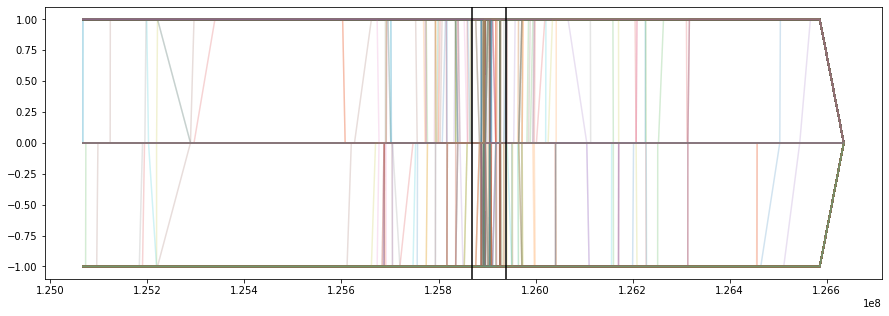

In [435]:
plt.figure(figsize=(15, 5))
for i in range(500):
    plt.plot(interval_bins[0, :], mat_match[i, :], alpha=0.2)
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.show()

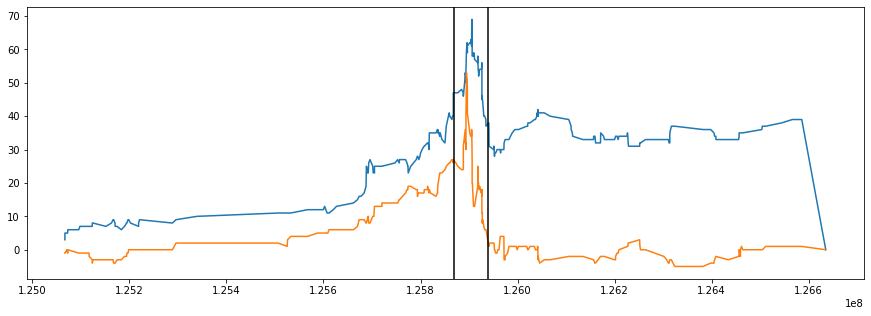

In [436]:
plt.figure(figsize=(15, 5))
plt.plot(interval_bins[0, :], np.sum(mat_match, axis=0))
plt.plot(interval_bins[0, :], np.sum(pat_match, axis=0))
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.show()

In [437]:
interval_indices = (interval_bins[0, :]>=125870000) & (interval_bins[1, :]<=125940000)
print(np.sum(interval_indices))

59


In [438]:
mat_changed = np.any(mat_match[:, interval_indices]==-1, axis=1) & np.any(mat_match[:, interval_indices]==1, axis=1)
pat_changed = np.any(pat_match[:, interval_indices]==-1, axis=1) & np.any(pat_match[:, interval_indices]==1, axis=1)
print(np.sum(mat_changed), np.sum(pat_changed), np.sum(mat_changed & pat_changed)/len(mat_changed), np.sum(mat_changed)/len(mat_changed), np.sum(pat_changed)/len(mat_changed))



126 111 0.0 0.17096336499321574 0.15061058344640435


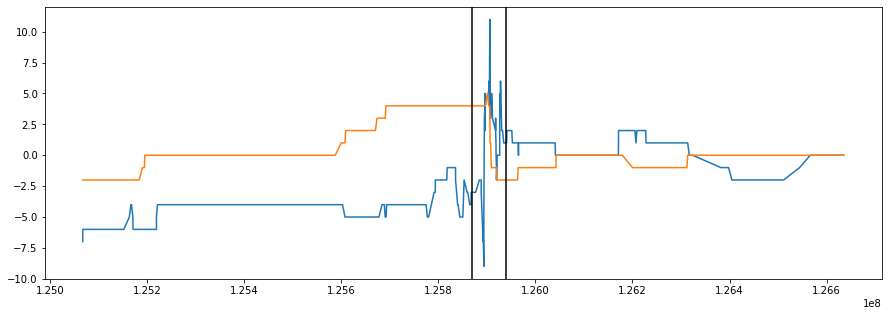

In [439]:
plt.figure(figsize=(15, 5))
plt.plot(interval_bins[0, :], np.sum(mat_match[mat_changed, :], axis=0))
plt.plot(interval_bins[0, :], np.sum(pat_match[mat_changed, :], axis=0))
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.show()

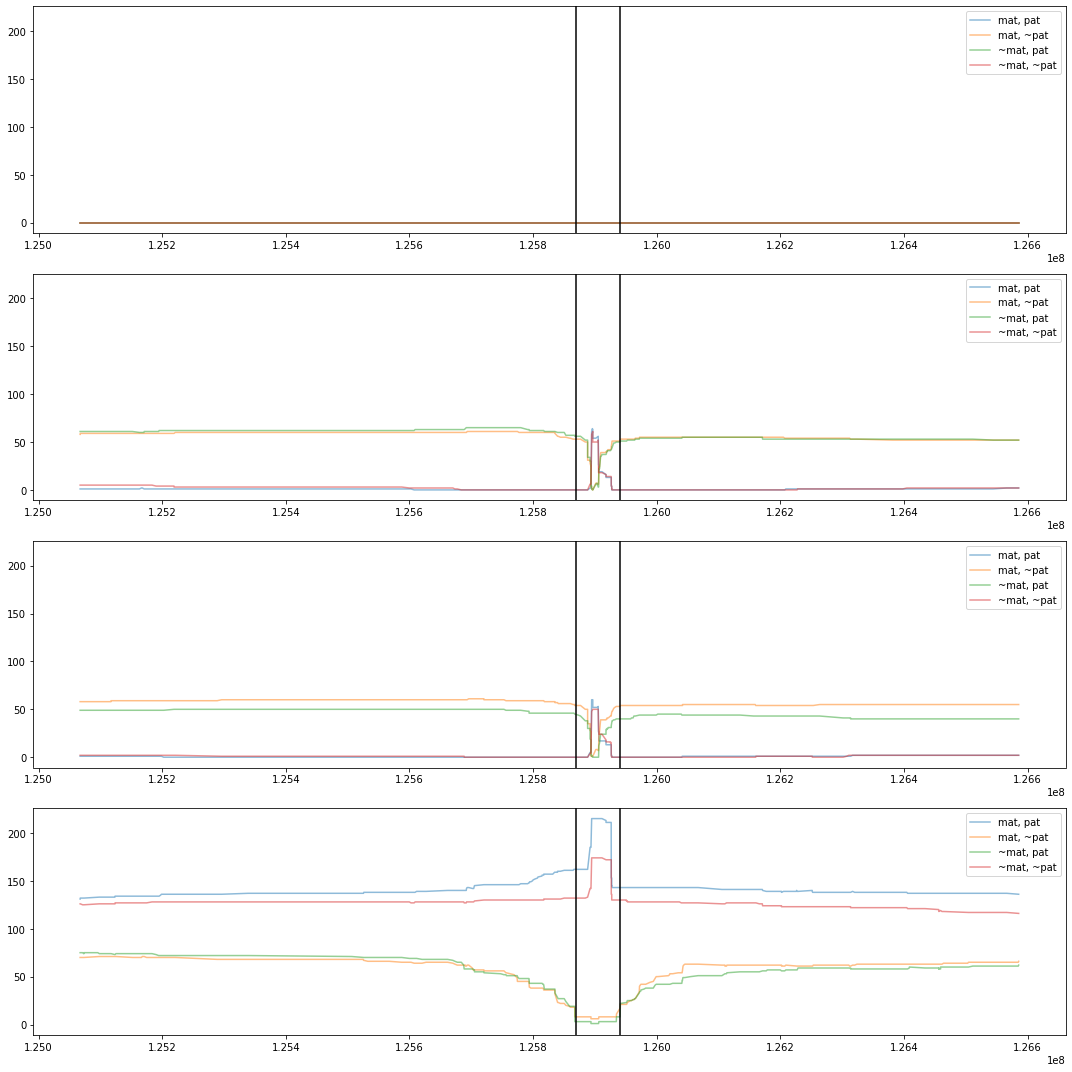

In [440]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(4, 1, 1)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[mat_changed & pat_changed, :-1]==1) & (pat_match[mat_changed & pat_changed, :-1]==1), axis=0), alpha=0.5, label='mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[mat_changed & pat_changed, :-1]==1) & (pat_match[mat_changed & pat_changed, :-1]==-1), axis=0), alpha=0.5, label='mat, ~pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[mat_changed & pat_changed, :-1]==-1) & (pat_match[mat_changed & pat_changed, :-1]==1), axis=0), alpha=0.5, label='~mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[mat_changed & pat_changed, :-1]==-1) & (pat_match[mat_changed & pat_changed, :-1]==-1), axis=0), alpha=0.5, label='~mat, ~pat')
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.legend()

plt.subplot(4, 1, 2, sharey=ax, sharex=ax)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[mat_changed & ~pat_changed, :-1]==1) & (pat_match[mat_changed & ~pat_changed, :-1]==1), axis=0), alpha=0.5, label='mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[mat_changed & ~pat_changed, :-1]==1) & (pat_match[mat_changed & ~pat_changed, :-1]==-1), axis=0), alpha=0.5, label='mat, ~pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[mat_changed & ~pat_changed, :-1]==-1) & (pat_match[mat_changed & ~pat_changed, :-1]==1), axis=0), alpha=0.5, label='~mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[mat_changed & ~pat_changed, :-1]==-1) & (pat_match[mat_changed & ~pat_changed, :-1]==-1), axis=0), alpha=0.5, label='~mat, ~pat')
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.legend()
#plt.ylim([60, None])
#plt.xlim([125600000, 126200000])

plt.subplot(4, 1, 3, sharey=ax, sharex=ax)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[~mat_changed & pat_changed, :-1]==1) & (pat_match[~mat_changed & pat_changed, :-1]==1), axis=0), alpha=0.5, label='mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[~mat_changed & pat_changed, :-1]==1) & (pat_match[~mat_changed & pat_changed, :-1]==-1), axis=0), alpha=0.5, label='mat, ~pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[~mat_changed & pat_changed, :-1]==-1) & (pat_match[~mat_changed & pat_changed, :-1]==1), axis=0), alpha=0.5, label='~mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[~mat_changed & pat_changed, :-1]==-1) & (pat_match[~mat_changed & pat_changed, :-1]==-1), axis=0), alpha=0.5, label='~mat, ~pat')
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.legend()

plt.subplot(4, 1, 4, sharey=ax, sharex=ax)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[~mat_changed & ~pat_changed, :-1]==1) & (pat_match[~mat_changed & ~pat_changed, :-1]==1), axis=0), alpha=0.5, label='mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[~mat_changed & ~pat_changed, :-1]==1) & (pat_match[~mat_changed & ~pat_changed, :-1]==-1), axis=0), alpha=0.5, label='mat, ~pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[~mat_changed & ~pat_changed, :-1]==-1) & (pat_match[~mat_changed & ~pat_changed, :-1]==1), axis=0), alpha=0.5, label='~mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[~mat_changed & ~pat_changed, :-1]==-1) & (pat_match[~mat_changed & ~pat_changed, :-1]==-1), axis=0), alpha=0.5, label='~mat, ~pat')
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.legend()

plt.tight_layout()
plt.show()

In [441]:
num_affected = np.array([x.num_affected for x in sibpairs])
num_males = np.array([x.num_males for x in sibpairs])
male_is_affected = np.array([(x.num_males==1) and ((sample_to_affected[x.sibling1]=='2' and sample_to_sex[x.sibling1]=='1') or sample_to_affected[x.sibling2]=='2' and sample_to_sex[x.sibling2]=='1') for x in sibpairs])

print(np.sum(male_is_affected), np.sum((num_males==1) & ~male_is_affected))

266 34


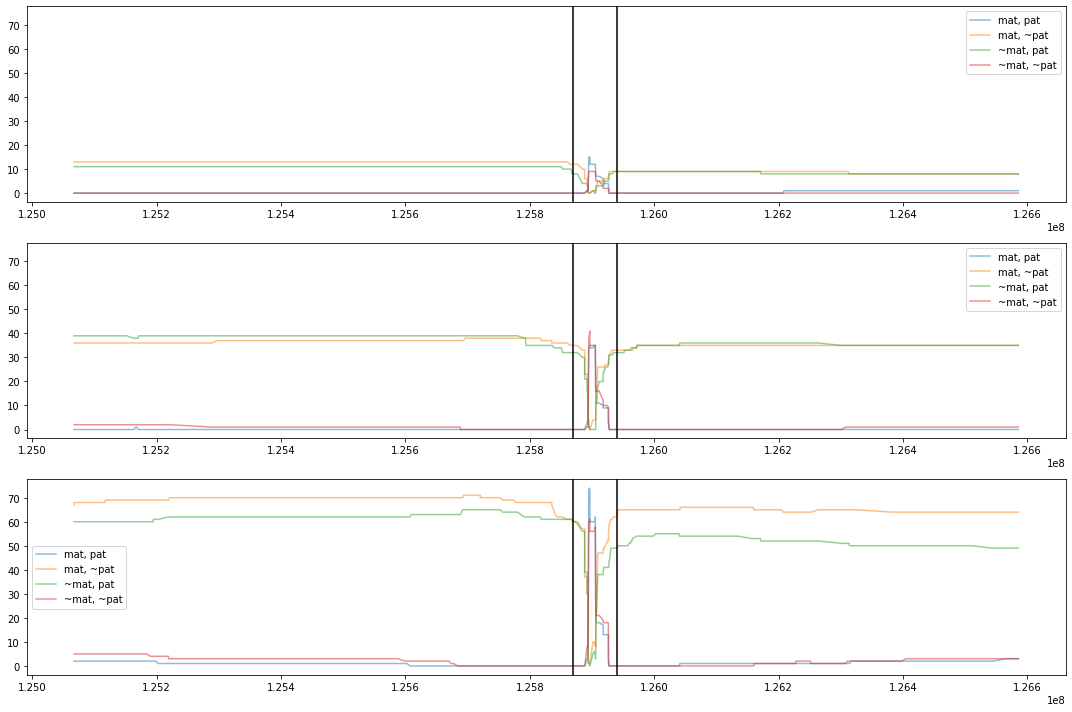

In [442]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(3, 1, 1)
x = ((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==0)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1), axis=0), alpha=0.5, label='mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==-1), axis=0), alpha=0.5, label='mat, ~pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==1), axis=0), alpha=0.5, label='~mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==-1), axis=0), alpha=0.5, label='~mat, ~pat')
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.legend()
#plt.ylim([60, None])
#plt.xlim([125600000, 126200000])

plt.subplot(3, 1, 2, sharey=ax, sharex=ax)
x = ((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==1)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1), axis=0), alpha=0.5, label='mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==-1), axis=0), alpha=0.5, label='mat, ~pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==1), axis=0), alpha=0.5, label='~mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==-1), axis=0), alpha=0.5, label='~mat, ~pat')
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.legend()

plt.subplot(3, 1, 3, sharey=ax, sharex=ax)
x = ((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==2)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1), axis=0), alpha=0.5, label='mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==-1), axis=0), alpha=0.5, label='mat, ~pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==1), axis=0), alpha=0.5, label='~mat, pat')
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==-1), axis=0), alpha=0.5, label='~mat, ~pat')
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.legend()

plt.tight_layout()
plt.show()

In [443]:
hasboth = np.any((mat_match[:, interval_indices]==1) & (pat_match[:, interval_indices]==1), axis=1)
hasneither = np.any((mat_match[:, interval_indices]==-1) & (pat_match[:, interval_indices]==-1), axis=1)
print(np.sum(hasboth), np.sum(hasneither), np.sum(hasboth & hasneither))

c = [[np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & hasboth & ~hasneither & (num_affected==0)), 
      np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & ~hasboth & hasneither & (num_affected==0))],
     [np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & hasboth & ~hasneither & (num_affected==1)), 
      np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & ~hasboth & hasneither & (num_affected==1))],
     [np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & hasboth & ~hasneither & (num_affected==2)), 
      np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & ~hasboth & hasneither & (num_affected==2))],]
try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum((mat_changed |  pat_changed) & (num_affected==0)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==0))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==2)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==2))]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==0)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==0))],
     [np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1))],
     [np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==2)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==2))]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_males==0)), 
      np.sum((~mat_changed & ~pat_changed) & (num_males==0))],
     [np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_males==1))],
     [np.sum(((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_males==2)), 
      np.sum((~mat_changed & ~pat_changed) & (num_males==2))]]

try:
    print('males', c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum((mat_changed |  pat_changed) & (num_affected==0) & (num_males==2)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==0) & (num_males==2))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==1) & (num_males==2)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1) & (num_males==2))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==2) & (num_males==2)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==2) & (num_males==2))]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum((mat_changed |  pat_changed) & (num_affected==0) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==0) & (num_males==1))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==1) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1) & (num_males==1))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==2) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==2) & (num_males==1))]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum((mat_changed |  pat_changed) & (num_affected==0) & (num_males==0)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==0) & (num_males==0))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==1) & (num_males==0)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1) & (num_males==0))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==2) & (num_males==0)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==2) & (num_males==0))]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum((mat_changed |  pat_changed) & (num_affected==0) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==0) & (num_males==1))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==1) & (num_males==1) & male_is_affected), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1) & (num_males==1) & male_is_affected)],
     [np.sum((mat_changed |  pat_changed) & (num_affected==2) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==2) & (num_males==1))]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum((mat_changed |  pat_changed) & (num_affected==0) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==0) & (num_males==1))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==1) & (num_males==1) & ~male_is_affected), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1) & (num_males==1) & ~male_is_affected)],
     [np.sum((mat_changed |  pat_changed) & (num_affected==2) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==2) & (num_males==1))]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]), c[2][0]/(c[2][0]+c[2][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum((mat_changed |  pat_changed) & (num_affected==0) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==0) & (num_males==1))],
     [np.sum((mat_changed |  pat_changed) & (num_affected==2) & (num_males==1)), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==2) & (num_males==1))]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

c = [[np.sum((mat_changed |  pat_changed) & (num_affected==1) & (num_males==1) & male_is_affected), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1) & (num_males==1) & male_is_affected)],
     [np.sum((mat_changed |  pat_changed) & (num_affected==1) & (num_males==1) & ~male_is_affected), 
      np.sum((~mat_changed & ~pat_changed) & (num_affected==1) & (num_males==1) & ~male_is_affected)]]

try:
    print(c, c[0][0]/(c[0][0]+c[0][1]), c[1][0]/(c[1][0]+c[1][1]))
    print(stats.chi2_contingency(c)[1])
except:
    pass

341 285 0
[[15, 9], [36, 41], [75, 61]] 0.625 0.4675324675324675 0.5514705882352942
0.3125781803573999
[[24, 32], [77, 127], [136, 341]] 0.42857142857142855 0.37745098039215685 0.2851153039832285
0.012497331512513008
[[24, 32], [77, 127], [136, 341]] 0.42857142857142855 0.37745098039215685 0.2851153039832285
0.012497331512513008
males [[27, 42], [93, 207], [117, 251]] 0.391304347826087 0.31 0.3179347826086957
0.4180350429616516
[[6, 11], [31, 53], [80, 187]] 0.35294117647058826 0.36904761904761907 0.299625468164794
0.4674769991456684
[[9, 11], [40, 60], [44, 136]] 0.45 0.4 0.24444444444444444
0.009873094734436982
[[9, 10], [6, 14], [12, 18]] 0.47368421052631576 0.3 0.4
0.5350267162103123
[[9, 11], [32, 54], [44, 136]] 0.45 0.37209302325581395 0.24444444444444444
0.031063901198858854
[[9, 11], [8, 6], [44, 136]] 0.45 0.5714285714285714 0.24444444444444444
0.007595270211456938
[[9, 11], [44, 136]] 0.45 0.24444444444444444
0.08744726370846045
[[32, 54], [8, 6]] 0.37209302325581395 0.57142

In [444]:
print(np.sum(X[:, 1])/X.shape[0])

0.25769230769230766


In [445]:
import statsmodels.api as sm

# given that sibling is affected, what's the chance of being affected
X = np.zeros((np.sum(num_affected>0), 5))
y = np.zeros((np.sum(num_affected>0),))

X[:, -1] = 1

for i, (sp, mc, pc, nm, hb, hn) in enumerate([x for x in zip(sibpairs, mat_changed, pat_changed, num_males, hasboth, hasneither) if x[0].num_affected>0]):
    X[i, 0] = (mc or pc) and hb
    X[i, 1] = (mc or pc) and hn
    if sample_to_affected[sp.sibling1]=='2':
        X[i, 2] = sample_to_sex[sp.sibling1]=='1'
        X[i, 3] = sample_to_sex[sp.sibling2]=='1'
    else:
        X[i, 2] = sample_to_sex[sp.sibling2]=='1'
        X[i, 3] = sample_to_sex[sp.sibling1]=='1'
    y[i] = sp.num_affected==2

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

# MSSNG for sibpairs with an affected child, if the sibpair has a change event, then the other sibling is less likely
# to be affected

# iHART sex of the affected sibling doesn't matter 
# MSSNG sex of the affected sibling matters - if affected sibling is M then other sibling is less likely to be affected

Optimization terminated successfully.
         Current function value: 0.564607
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  681
Model:                          Logit   Df Residuals:                      676
Method:                           MLE   Df Model:                            4
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                 0.07516
Time:                        15:16:40   Log-Likelihood:                -384.50
converged:                       True   LL-Null:                       -415.74
Covariance Type:            nonrobust   LLR p-value:                 8.676e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3262      0.237     -1.374      0.169      -0.792       0.139
x2            -0.5350      0.

In [446]:
# given that sibling is unaffected, what's the chance of being affected
X = np.zeros((np.sum(num_affected<2), 5))
y = np.zeros((np.sum(num_affected<2),))

X[:, -1] = 1

for i, (sp, mc, pc, nm, hb, hn) in enumerate([x for x in zip(sibpairs, mat_changed, pat_changed, num_males, hasboth, hasneither) if x[0].num_affected<2]):
    X[i, 0] = (mc or pc) and hb
    X[i, 1] = (mc or pc) and hn
    if sample_to_affected[sp.sibling1]=='1':
        X[i, 2] = sample_to_sex[sp.sibling1]=='1'
        X[i, 3] = sample_to_sex[sp.sibling2]=='1'
    else:
        X[i, 2] = sample_to_sex[sp.sibling2]=='1'
        X[i, 3] = sample_to_sex[sp.sibling1]=='1'
    y[i] = sp.num_affected==1

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

# iHART and MSSNG sex of the unaffected sibling doesn't matter 

Optimization terminated successfully.
         Current function value: 0.481133
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  260
Model:                          Logit   Df Residuals:                      255
Method:                           MLE   Df Model:                            4
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                 0.07653
Time:                        15:16:50   Log-Likelihood:                -125.09
converged:                       True   LL-Null:                       -135.46
Covariance Type:            nonrobust   LLR p-value:                 0.0003577
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4616      0.384     -1.202      0.229      -1.214       0.291
x2             0.2497      0.

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


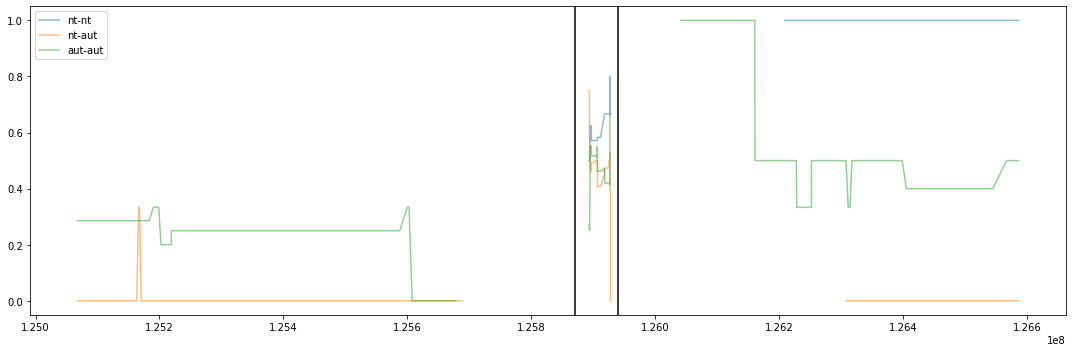

In [447]:
plt.figure(figsize=(15, 5))
x = ((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==0)
#x = (mat_changed | pat_changed) & (num_affected==0)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1), axis=0)/np.sum(((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1)) | ((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==-1)), axis=0), 
         alpha=0.5, label='nt-nt')
x = ((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==1)
#x = (mat_changed | pat_changed) & (num_affected==1)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1), axis=0)/np.sum(((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1)) | ((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==-1)), axis=0), 
         alpha=0.5, label='nt-aut')
x = ((mat_changed & ~pat_changed) | (~mat_changed & pat_changed)) & (num_affected==2)
#x = (mat_changed | pat_changed) & (num_affected==2)
plt.plot(interval_bins[0, :-1], np.sum((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1), axis=0)/np.sum(((mat_match[x, :-1]==1) & (pat_match[x, :-1]==1)) | ((mat_match[x, :-1]==-1) & (pat_match[x, :-1]==-1)), axis=0), 
         alpha=0.5, label='aut-aut')

plt.legend()
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.tight_layout()
plt.show()

In [449]:
sibpairs_of_interest = [sibpairs[i] for i in np.where((mat_changed | pat_changed) & hasneither)[0]]
print(len(sibpairs_of_interest))

111


In [638]:
ped_file = '../../DATA/mssng/mssng.ped'
sample_file = '../../DATA/mssng/genotypes/samples.json'
ad_file = '../depth/mssng_chr10.npy'
positions_file = '../depth/mssng_chr10_positions.npy'

start_pos, end_pos = 125870000, 125940000

In [451]:
ad = np.load(ad_file)
snp_positions = np.load(positions_file)
print(ad.shape)
print(snp_positions)

(9621, 156645, 2)
[123796868 123796869 123796881 ... 126917536 126917540 126917555]


In [583]:
chrom = '10'
data_dir = '../../DATA/mssng/genotypes'
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
coord_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
sample_file = '%s/samples.json' % data_dir

# read samples
with open(sample_file, 'r') as f:
    samples = json.load(f)
    sample_id_to_index = dict([(x, i) for i, x in enumerate(samples)])

all_gens, all_poss = [], []

for gen_file, coord_file in zip(gen_files, coord_files):
    coords = np.load('%s/%s' % (data_dir, coord_file))

    if coords.shape[0]>0:
        poss = coords[:, 1]
        is_snp = coords[:, 2]==1
        is_pass = coords[:, 3]==1

        in_interval = (coords[:, 1]>=start_pos) & (coords[:, 1]<=end_pos) & is_snp & is_pass
        if np.sum(in_interval)>0:
            gen = sparse.load_npz('%s/%s' % (data_dir, gen_file))[:, in_interval].A
            all_poss.append(poss[in_interval])
            all_gens.append(gen)
all_gens = np.hstack(all_gens)
all_poss = np.hstack(all_poss)

In [452]:
with open(sample_file, 'r') as f:
    samples = json.load(f)
sample_to_index = dict([(x, i) for i, x in enumerate(samples)])
print(len(samples))

9621


In [563]:
quad_indices = []
for sp in sibpairs:
    quad_indices.append([sample_to_index[sp.mom], sample_to_index[sp.dad], 
                                 sample_to_index[sp.sibling1], sample_to_index[sp.sibling2]])
quad_indices = np.array(quad_indices)
print(quad_indices.shape)

quad_ad = ad[:, (snp_positions>=start_pos) & (snp_positions<=end_pos), :][quad_indices, :, :]
all_quad_ad = ad[quad_indices, :, :]
print(quad_ad.shape)
                           
pos = snp_positions[(snp_positions>=start_pos) & (snp_positions<=end_pos)]

(737, 4)
(737, 4, 2855, 2)


In [584]:
quad_gens = all_gens[quad_indices, :]

In [618]:
print(mat_match[index, 0])
print(pat_match[index, 0])

1
-1


In [629]:
print(set([tuple(x) for x in np.array(list(product(*[[0, 1]]*4))).dot([[1, 0, 1, 1 if mat_match[index, 0]==1 else 0],
                                                [1, 0, 0, 0 if mat_match[index, 0]==1 else 1],
                                                [0, 1, 1, 1 if pat_match[index, 0]==1 else 0],
                                                [0, 1, 0, 0 if pat_match[index, 0]==1 else 1]]).tolist()]))
    

{(1, 1, 0, 1), (1, 0, 1, 1), (2, 1, 2, 1), (1, 0, 0, 0), (1, 1, 1, 0), (2, 1, 1, 2), (2, 2, 2, 2), (1, 2, 1, 1), (1, 1, 2, 1), (0, 2, 1, 1), (0, 0, 0, 0), (0, 1, 1, 0), (1, 1, 1, 2), (0, 1, 0, 1), (1, 2, 2, 2), (2, 0, 1, 1)}


In [632]:
print(quad_gens[index, :, has_alt].tolist())

[[1, 0, 1, 1], [1, 1, 2, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [1, 0, 1, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [1, 0, 1, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 0, 1], [1, 1, 0, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [1, 0, 1, 1], [0, 2, 1, 1], [1, 0, 1, 1], [0, 1, 0, 1], [0, 1, 0, 0], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [0, 1, 1, 0], [0, 1, 1, 0], [1, 1, 2, 1], [0, 1, 1, 0], [1, 1, 2, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [1, 1, 2, 1], [2, 2, 2, 2], [1, 0, 1, 1], [0, 1, 0, 1], [1, 1, 1, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [1, 1, 2, 1], [1, 1, 2, 1], [1, 1, 2, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [1, 1, 1, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [0, 1, 1, 0], [1, 1, 2, 1], [1, 0, 1, 1], [1, 1

In [826]:
changed_indices = (mat_changed | pat_changed) & (((mat_match[:, 0]==1) & (pat_match[:, 0]==-1)) | ((mat_match[:, 0]==-1) & (pat_match[:, 0]==1)))
notchanged_indices = ~(mat_changed | pat_changed) & (((mat_match[:, 0]==1) & (pat_match[:, 0]==-1)) | ((mat_match[:, 0]==-1) & (pat_match[:, 0]==1)))

In [827]:
print(quad_gens.shape)

(737, 4, 2855)


In [854]:
all_famgens = [tuple(x) for x in product(*[[0, 1, 2]]*4)]
famgen_to_index = dict([(x, i) for i, x in enumerate(all_famgens)])
famgen_counts = np.zeros((quad_gens.shape[0], len(all_famgens)), dtype=int)

for quad_index in range(quad_gens.shape[0]):
    famgens, counts = np.unique(quad_gens[quad_index, :, :], return_counts=True, axis=1)

    for famgen, count in zip(famgens.T, counts):
        if tuple(famgen) in famgen_to_index:
            famgen_counts[quad_index, famgen_to_index[tuple(famgen)]] = count

In [865]:
print(famgen_counts[:, 5])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [909]:
p_of_sibs_given_parents = np.zeros((famgen_counts.shape[0], 6, 6))
total_p_of_sibs_given_parents = np.zeros((6, 6, 2))
for i, (mom, dad) in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]]):
    total = np.zeros((famgen_counts.shape[0],), dtype=int)
    for sib1, sib2 in product(*[[0, 1, 2]]*2):
        total += famgen_counts[:, famgen_to_index[(mom, dad, sib1, sib2)]]
        if mom != dad:
            total += famgen_counts[:, famgen_to_index[(dad, mom, sib1, sib2)]]

    
    for j, (sib1, sib2) in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]]):
        if mom != dad and sib1 != sib2:
            p_of_sibs_given_parents[:, i, j] = (famgen_counts[:, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[:, famgen_to_index[(dad, mom, sib1, sib2)]]+famgen_counts[:, famgen_to_index[(mom, dad, sib2, sib1)]]+famgen_counts[:, famgen_to_index[(dad, mom, sib2, sib1)]])/total
            total_p_of_sibs_given_parents[i, j, 0] += np.sum(famgen_counts[changed_indices, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[changed_indices, famgen_to_index[(dad, mom, sib1, sib2)]]+famgen_counts[changed_indices, famgen_to_index[(mom, dad, sib2, sib1)]]+famgen_counts[changed_indices, famgen_to_index[(dad, mom, sib2, sib1)]])
            total_p_of_sibs_given_parents[i, j, 1] += np.sum(famgen_counts[notchanged_indices, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[notchanged_indices, famgen_to_index[(dad, mom, sib1, sib2)]]+famgen_counts[notchanged_indices, famgen_to_index[(mom, dad, sib2, sib1)]]+famgen_counts[notchanged_indices, famgen_to_index[(dad, mom, sib2, sib1)]])
        elif mom != dad:
            p_of_sibs_given_parents[:, i, j] = (famgen_counts[:, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[:, famgen_to_index[(dad, mom, sib1, sib2)]])/total
            total_p_of_sibs_given_parents[i, j, 0] += np.sum(famgen_counts[changed_indices, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[changed_indices, famgen_to_index[(dad, mom, sib1, sib2)]])
            total_p_of_sibs_given_parents[i, j, 1] += np.sum(famgen_counts[notchanged_indices, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[notchanged_indices, famgen_to_index[(dad, mom, sib1, sib2)]])
        elif sib1 != sib2:
            p_of_sibs_given_parents[:, i, j] = (famgen_counts[:, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[:, famgen_to_index[(mom, dad, sib2, sib1)]])/total
            total_p_of_sibs_given_parents[i, j, 0] += np.sum(famgen_counts[changed_indices, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[changed_indices, famgen_to_index[(mom, dad, sib2, sib1)]])
            total_p_of_sibs_given_parents[i, j, 1] += np.sum(famgen_counts[notchanged_indices, famgen_to_index[(mom, dad, sib1, sib2)]]+famgen_counts[notchanged_indices, famgen_to_index[(mom, dad, sib2, sib1)]])
        else:
            p_of_sibs_given_parents[:, i, j] = famgen_counts[:, famgen_to_index[(mom, dad, sib1, sib2)]]/total
            total_p_of_sibs_given_parents[i, j, 0] += np.sum(famgen_counts[changed_indices, famgen_to_index[(mom, dad, sib1, sib2)]])
            total_p_of_sibs_given_parents[i, j, 1] += np.sum(famgen_counts[notchanged_indices, famgen_to_index[(mom, dad, sib1, sib2)]])
        
        

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


In [937]:
print(np.sum(changed_indices), np.sum(notchanged_indices))

226 145


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


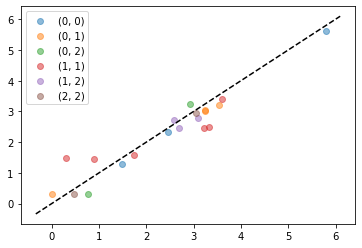

In [933]:
for i, l in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]]):
    plt.scatter(np.log10(total_p_of_sibs_given_parents[i, :, 0]), 
            np.log10(total_p_of_sibs_given_parents[i, :, 1]), 
                alpha=0.5, label=str(l))
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.legend()
plt.show()

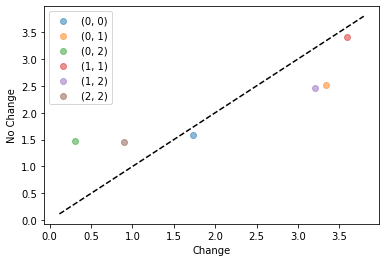

In [935]:
for i, l in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]]):
    plt.scatter(np.log10(total_p_of_sibs_given_parents[3, i, 0]), 
            np.log10(total_p_of_sibs_given_parents[3, i, 1]), 
                alpha=0.5, label=str(l))
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Change')
plt.ylabel('No Change')
plt.legend()
plt.show()

In [924]:
for i, (mom, dad) in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]]):
    print(mom, dad)
    c = np.array([[total_p_of_sibs_given_parents[i, j, 0], total_p_of_sibs_given_parents[i, j, 1]] for j in range(6)])
    print(c)
    print(c/np.sum(c, axis=0))
    try:
        print('pvalue', stats.chi2_contingency(c[np.sum(c, axis=1)>0, :])[1])
    except:
        pass
        
        

0 0
[[6.25811e+05 4.02325e+05]
 [2.89000e+02 2.08000e+02]
 [0.00000e+00 0.00000e+00]
 [3.00000e+01 1.90000e+01]
 [1.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00]]
[[9.99488925e-01 9.99436098e-01]
 [4.61564752e-04 5.16703432e-04]
 [0.00000000e+00 0.00000000e+00]
 [4.79132961e-05 4.71988712e-05]
 [1.59710987e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]
pvalue 0.534299191160335
0 1
[[1.769e+03 1.015e+03]
 [3.417e+03 1.574e+03]
 [4.000e+00 0.000e+00]
 [1.706e+03 1.149e+03]
 [1.000e+00 2.000e+00]
 [0.000e+00 0.000e+00]]
[[2.56488328e-01 2.71390374e-01]
 [4.95432797e-01 4.20855615e-01]
 [5.79962302e-04 0.00000000e+00]
 [2.47353922e-01 3.07219251e-01]
 [1.44990576e-04 5.34759358e-04]
 [0.00000000e+00 0.00000000e+00]]
pvalue 1.1512732414872289e-13
0 2
[[   0.    0.]
 [   6.    2.]
 [   0.    0.]
 [ 850. 1797.]
 [   0.    2.]
 [   0.    0.]]
[[0.         0.        ]
 [0.00700935 0.00111049]
 [0.         0.        ]
 [0.99299065 0.99777901]
 [0.         0.00111049]
 [0.         0.  

In [ ]:
plt.figure(figsize=(15, 15))

for i, (mom, dad) in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]]):
    plt.subplot(3, 3, i+1)
    plt.title('%d %d' % (mom, dad))
    plt.violinplot([x[~np.isnan(x)] for x in p_of_sibs_given_parents[changed_indices, i, :].T if np.sum(~np.isnan(x))>0])
    plt.violinplot([x[~np.isnan(x)] for x in p_of_sibs_given_parents[notchanged_indices, i, :].T if np.sum(~np.isnan(x))>0])
    plt.xticks(np.arange(1, 7), [str(x) for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]])
plt.tight_layout()
plt.show()

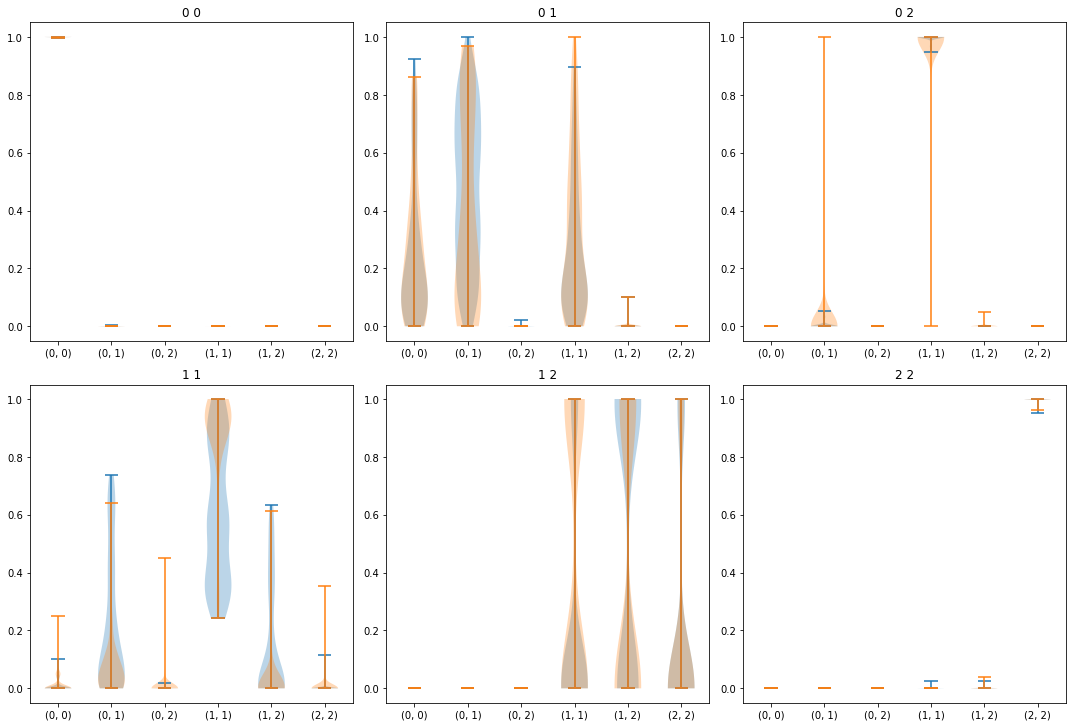

In [904]:
plt.figure(figsize=(15, 15))

for i, (mom, dad) in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]]):
    plt.subplot(3, 3, i+1)
    plt.title('%d %d' % (mom, dad))
    plt.violinplot([x[~np.isnan(x)] for x in p_of_sibs_given_parents[changed_indices, i, :].T if np.sum(~np.isnan(x))>0])
    plt.violinplot([x[~np.isnan(x)] for x in p_of_sibs_given_parents[notchanged_indices, i, :].T if np.sum(~np.isnan(x))>0])
    plt.xticks(np.arange(1, 7), [str(x) for x in product(*[[0, 1, 2]]*2) if x[0]<=x[1]])
plt.tight_layout()
plt.show()

In [871]:
print(len(all_famgens))
print(np.sum(np.sum(famgen_counts, axis=0)>10))

81
32


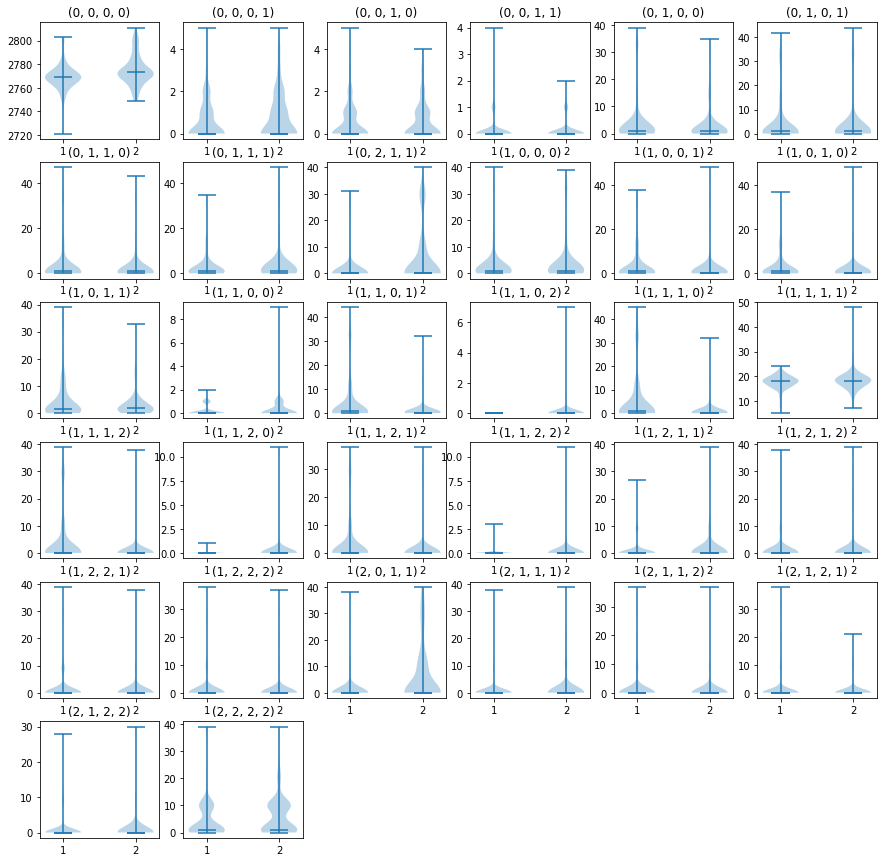

In [876]:
plt.figure(figsize=(15, 15))
index = 0
for i, j in enumerate(np.where(np.sum(famgen_counts, axis=0)>10)[0]):
    plt.subplot(6, 6, i+1)
    plt.violinplot([famgen_counts[changed_indices, j], famgen_counts[notchanged_indices, j]], showmedians=True)
    plt.title(str(all_famgens[j]))
    
plt.tight_layout()
plt.show()

In [824]:
num_errors = np.zeros((pos.shape[0],))
num_errors_fixed_same = np.zeros((pos.shape[0],))
num_errors_fixed_diff = np.zeros((pos.shape[0],))
num_errors_fixed = np.zeros((pos.shape[0],))

num_super_het = np.zeros((pos.shape[0],))
qs = ~(mat_changed | pat_changed) & (((mat_match[:, 0]==1) & (pat_match[:, 0]==-1)) | ((mat_match[:, 0]==-1) & (pat_match[:, 0]==1)))
for index in np.where(qs)[0]:
    mindex = np.argmax((mat_match[index, :]==-1) & (pat_match[index, :]==-1))
    spos = interval_bins[0, mindex]
    epos = interval_bins[1, mindex+np.argmin((mat_match[index, mindex:]==-1) & (pat_match[index, mindex:]==-1))]

    anc_vars = np.array(list(product(*[[0, 1]]*4)))
    famgens = set([tuple(x) for x in anc_vars.dot([[1, 0, 1, 1 if mat_match[index, 0]==1 else 0],
                                                    [1, 0, 0, 0 if mat_match[index, 0]==1 else 1],
                                                    [0, 1, 1, 1 if pat_match[index, 0]==1 else 0],
                                                    [0, 1, 0, 0 if pat_match[index, 0]==1 else 1]]).tolist()])
    isok = np.array([tuple(x) in famgens for x in quad_gens[index, :, :].T.tolist()])
    num_errors += ~isok
    
    famgens = set([tuple(x) for x in anc_vars.dot([[1, 0, 1, 1],
                                                [1, 0, 0, 0],
                                                [0, 1, 1, 1],
                                                [0, 1, 0, 0]]).tolist()])
    isok_same = np.array([tuple(x) in famgens for x in quad_gens[index, :, :].T.tolist()])
    num_errors_fixed_same += ~isok_same
    
    famgens = set([tuple(x) for x in anc_vars.dot([[1, 0, 1, 0],
                                                [1, 0, 0, 1],
                                                [0, 1, 1, 0],
                                                [0, 1, 0, 1]]).tolist()])
    isok_diff = np.array([tuple(x) in famgens for x in quad_gens[index, :, :].T.tolist()])
    num_errors_fixed_diff += ~isok_diff
    
    if np.sum(~isok_diff[(pos>=125896000) & (pos<=125906000)]) > np.sum(~isok_same[(pos>=125896000) & (pos<=125906000)]):
        num_errors_fixed[(pos>=125896000) & (pos<=125906000)] += ~isok_same[(pos>=125896000) & (pos<=125906000)]
    elif np.sum(~isok_same[(pos>=125896000) & (pos<=125906000)]) > np.sum(~isok_diff[(pos>=125896000) & (pos<=125906000)]):
        num_errors_fixed[(pos>=125896000) & (pos<=125906000)] += ~isok_diff[(pos>=125896000) & (pos<=125906000)]
        
    num_super_het[(pos>=spos) & (pos<=epos)] += np.array([tuple(x)==(1, 1, 1, 1) for x in quad_gens[index, :, :].T.tolist()])[(pos>=spos) & (pos<=epos)]
    

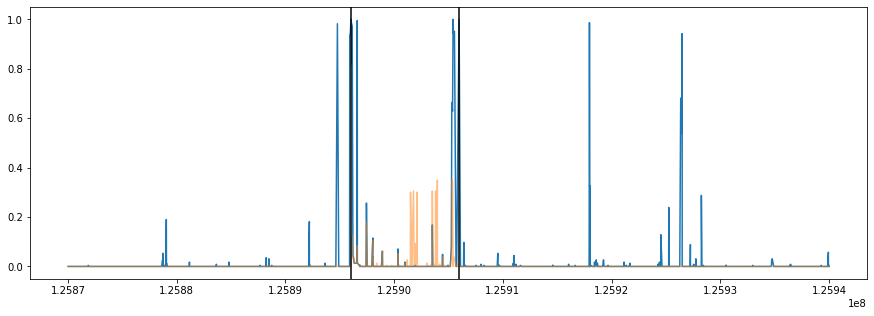

In [823]:
plt.figure(figsize=(15, 5))
plt.plot(pos, num_errors/np.sum(qs))
plt.plot(pos, num_errors_fixed/np.sum(qs), alpha=0.5)
#plt.plot(pos, num_errors_fixed_diff/np.sum(qs), alpha=0.5)
#plt.plot(pos, num_super_het, alpha=0.5)
plt.axvline(125896000, color='black')
plt.axvline(125906000, color='black')
plt.show()

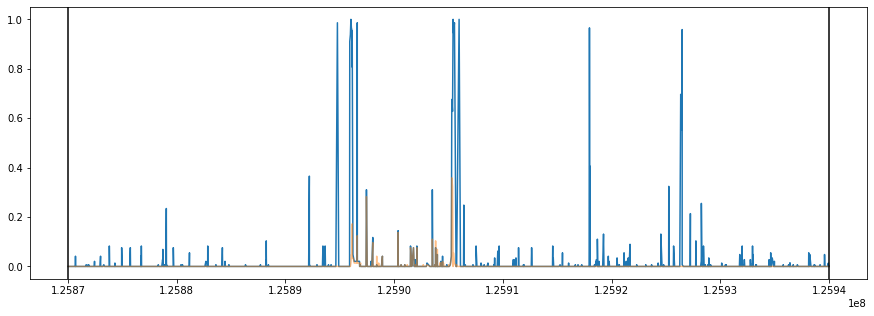

In [825]:
plt.figure(figsize=(15, 5))
plt.plot(pos, num_errors/np.sum(qs))
plt.plot(pos, num_errors_fixed/np.sum(qs), alpha=0.5)
#plt.plot(pos, num_errors_fixed_diff/np.sum(qs), alpha=0.5)
#plt.plot(pos, num_super_het, alpha=0.5)
plt.axvline(125870000, color='black')
plt.axvline(125940000, color='black')
plt.show()

In [761]:
super_error = (num_errors/np.sum(mat_changed | pat_changed))>0.8
print(np.sum(super_error))

16


In [762]:
print(pos[super_error])

[125894783 125895919 125895977 125896024 125896070 125896137 125896138
 125896144 125896600 125896610 125905425 125905456 125905549 125905975
 125917965 125926492]


In [786]:
i = pos.tolist().index(125926492)
print(Counter([tuple(x) for x in quad_gens[:, :, i].tolist()]))
print(Counter([tuple(x) for x in quad_gens[(mat_changed | pat_changed), :, i].tolist()]))
print(Counter([tuple(x) for x in quad_gens[qs, :, i].tolist()]))


Counter({(1, 1, 1, 1): 689, (1, 1, 0, 1): 14, (1, 0, 1, 1): 12, (0, 1, 1, 1): 11, (1, 1, 1, 0): 9, (1, 0, 0, 1): 2})
Counter({(1, 1, 1, 1): 217, (1, 1, 0, 1): 7, (1, 0, 1, 1): 5, (0, 1, 1, 1): 4, (1, 1, 1, 0): 3, (1, 0, 0, 1): 1})
Counter({(1, 1, 1, 1): 231, (1, 1, 0, 1): 4, (0, 1, 1, 1): 3, (1, 0, 1, 1): 2, (1, 1, 1, 0): 2, (1, 0, 0, 1): 1})


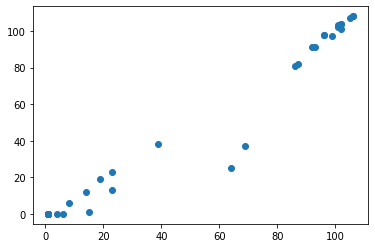

In [722]:
plt.scatter(num_errors[num_errors>num_errors_fixed], num_super_het[num_errors>num_errors_fixed])
plt.show()

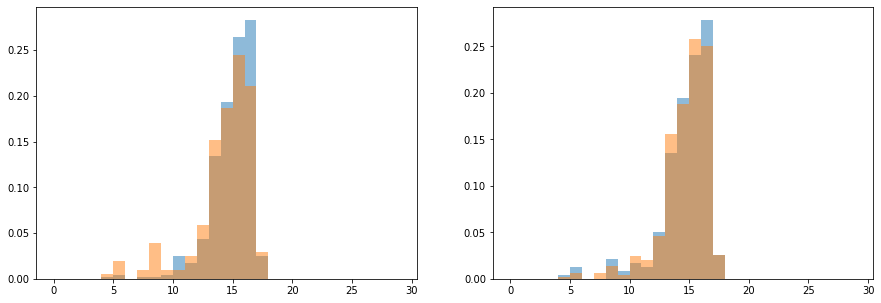

In [724]:
super_het = np.sum((quad_gens[:, 0, super_error]==1) & (quad_gens[:, 1, super_error]==1) & (quad_gens[:, 2, super_error]==1) & (quad_gens[:, 3, super_error]==1), axis=1)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
#plt.hist(super_het, density=True, alpha=0.5, bins=np.arange(0, 70))
plt.hist(super_het[num_affected==2], density=True, alpha=0.5, bins=np.arange(0, 30))
plt.hist(super_het[num_affected==1], density=True, alpha=0.5, bins=np.arange(0, 30))
#plt.hist(super_het[num_affected==0], density=True, alpha=0.5, bins=np.arange(0, 30))
#plt.hist(super_het[num_affected==1], density=True, alpha=0.5, bins=np.arange(0, 30))
#plt.hist(super_het[num_affected==2], density=True, alpha=0.5, bins=np.arange(0, 30))

plt.subplot(1, 2, 2)
#plt.hist(super_het, density=True, alpha=0.5, bins=np.arange(0, 70))
plt.hist(super_het[(mat_changed | pat_changed)], density=True, alpha=0.5, bins=np.arange(0, 30))
plt.hist(super_het[~((mat_changed | pat_changed))], density=True, alpha=0.5, bins=np.arange(0, 30))

plt.show()

In [720]:
p = 125895977
i = pos.tolist().index(p)
print(Counter([tuple(x) for x in quad_gens[(mat_changed | pat_changed) & hasneither, :, i].tolist()]))
print(Counter([tuple(x) for x in quad_gens[:, :, i].tolist()]))

Counter({(1, 1, 1, 1): 103, (1, 1, 0, 1): 3, (0, 0, 0, 1): 2, (0, 0, 1, 1): 1, (0, 1, 1, 1): 1, (1, 1, 1, 0): 1})
Counter({(1, 1, 1, 1): 665, (1, 1, 1, 0): 16, (0, 1, 1, 1): 14, (1, 0, 1, 1): 14, (0, 0, 0, 1): 8, (1, 1, 0, 1): 8, (0, 0, 1, 1): 4, (0, -1, 1, 1): 3, (-1, -1, -1, 1): 2, (0, -1, -1, 1): 2, (1, 1, 0, 0): 1})


In [665]:
print(pos[num_errors>100])
print(pos[num_errors>num_errors_fixed])

[125894783 125895919 125895977 125896024 125896070 125896137 125896144
 125896610]
[125892202 125892305 125893451 125893653 125894783 125895919 125895977
 125896024 125896070 125896137 125896138 125896143 125896144 125896600
 125896610 125905265 125905304 125905373 125905425 125905456 125905549
 125905975 125907536 125909245 125909284 125911207 125911444 125912645
 125914636 125917965 125917991 125919698 125920503 125921531 125925260
 125926357 125926468 125926492]


125894783 125927755
22
8


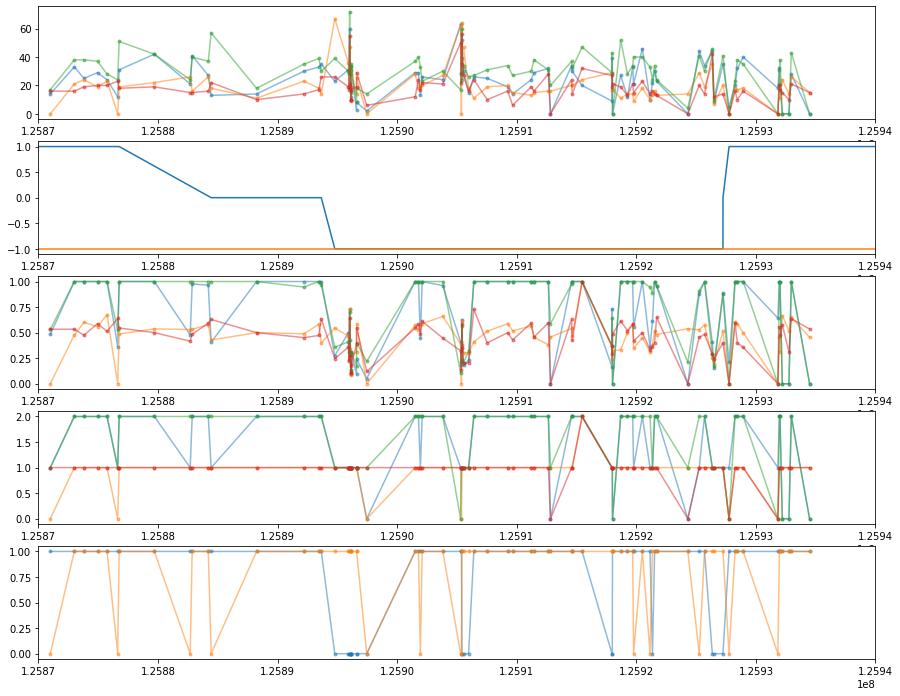

In [653]:
index = random.choice(np.where((mat_changed | pat_changed) & hasneither & (num_affected==1))[0])
has_alt = np.any(quad_gens[index, :, :]>0, axis=0)

mindex = np.argmax((mat_match[index, :]==-1) & (pat_match[index, :]==-1))
spos = interval_bins[0, mindex]
epos = interval_bins[1, mindex+np.argmin((mat_match[index, mindex:]==-1) & (pat_match[index, mindex:]==-1))]
print(spos, epos)

plt.figure(figsize=(15, 12))

ax = plt.subplot(5, 1, 1)
plt.plot(pos[has_alt], quad_ad[index, 0, has_alt, 1], alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_ad[index, 1, has_alt, 1], alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_ad[index, 2, has_alt, 1], alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_ad[index, 3, has_alt, 1], alpha=0.5, marker='.')

plt.subplot(5, 1, 2, sharex=ax)
plt.plot(interval_bins[0, :], mat_match[index, :])
plt.plot(interval_bins[0, :], pat_match[index, :])
plt.xlim([125870000, 125940000])

plt.subplot(5, 1, 3, sharex=ax)
plt.plot(pos[has_alt], quad_ad[index, 0, has_alt, 1]/np.sum(quad_ad[index, 0, has_alt, :], axis=1), alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_ad[index, 1, has_alt, 1]/np.sum(quad_ad[index, 1, has_alt, :], axis=1), alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_ad[index, 2, has_alt, 1]/np.sum(quad_ad[index, 2, has_alt, :], axis=1), alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_ad[index, 3, has_alt, 1]/np.sum(quad_ad[index, 3, has_alt, :], axis=1), alpha=0.5, marker='.')

plt.subplot(5, 1, 4, sharex=ax)
plt.plot(pos[has_alt], quad_gens[index, 0, has_alt], alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_gens[index, 1, has_alt], alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_gens[index, 2, has_alt], alpha=0.5, marker='.')
plt.plot(pos[has_alt], quad_gens[index, 3, has_alt], alpha=0.5, marker='.')

plt.subplot(5, 1, 5, sharex=ax)
anc_vars = np.array(list(product(*[[0, 1]]*4)))
famgens = set([tuple(x) for x in anc_vars.dot([[1, 0, 1, 1 if mat_match[index, 0]==1 else 0],
                                                [1, 0, 0, 0 if mat_match[index, 0]==1 else 1],
                                                [0, 1, 1, 1 if pat_match[index, 0]==1 else 0],
                                                [0, 1, 0, 0 if pat_match[index, 0]==1 else 1]]).tolist()])

isok = np.array([tuple(x) in famgens for x in quad_gens[index, :, :].T.tolist()])
plt.plot(pos[has_alt], isok[has_alt], marker='.', alpha=0.5)
print(np.sum(~isok[(pos>=spos) & (pos<=epos)]))

famgens = set([tuple(x) for x in anc_vars.dot([[1, 0, 1, 0],
                                                [1, 0, 0, 1],
                                                [0, 1, 1, 0],
                                                [0, 1, 0, 1]]).tolist()])

isok = np.array([tuple(x) in famgens for x in quad_gens[index, :, :].T.tolist()])
plt.plot(pos[has_alt], isok[has_alt], marker='.', alpha=0.5)
print(np.sum(~isok[(pos>=spos) & (pos<=epos)]))

plt.show()

In [591]:
print(pos[has_alt][quad_ad[index, 2, has_alt, 1]>100])

[125905425 125905456]


1341


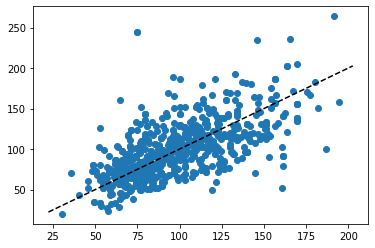

In [603]:
var_index = np.where(pos==125905425)[0][0]
print(var_index)

plt.scatter((quad_ad[:, 0, var_index, 1]+quad_ad[:, 1, var_index, 1])/2, quad_ad[:, 3, var_index, 1])
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()

2 0
0.3968476357267951 0.3208337323246832
0.4830122591943958 0.6503303648376904
0.5460595446584938 0.7262472469596859
0.6252189141856392 0.6074627342079224


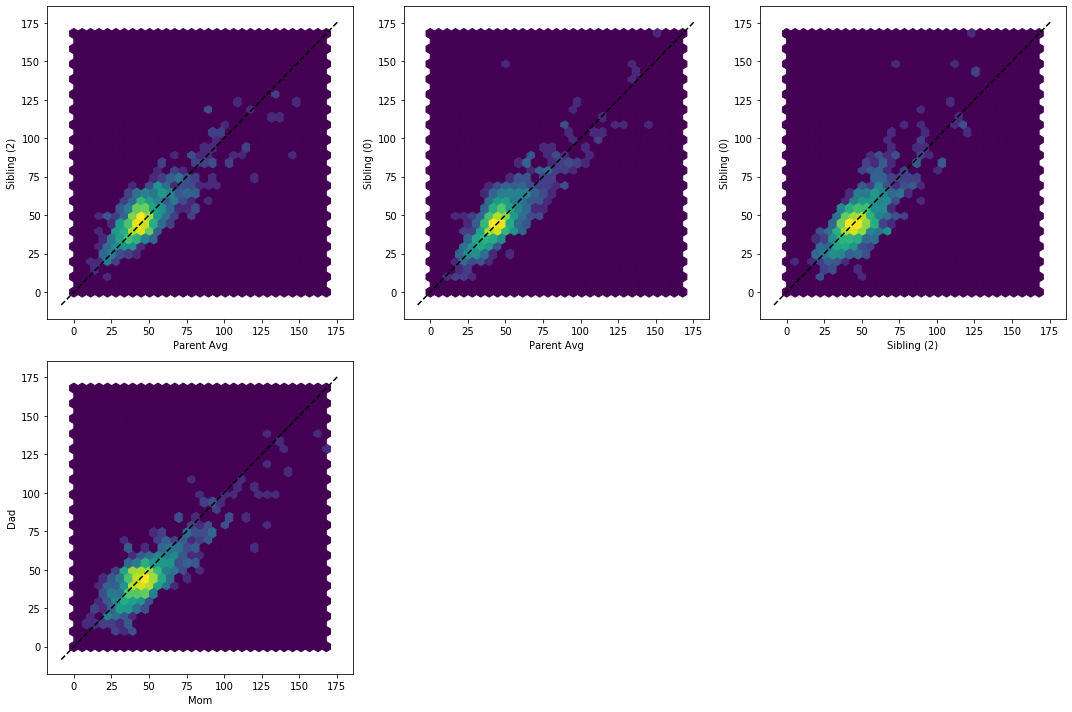

In [562]:
index = random.choice(np.where((mat_changed | pat_changed) & hasneither & (num_affected==1))[0])
print(sample_to_affected[sibpairs[index].sibling1], sample_to_affected[sibpairs[index].sibling2])

plt.figure(figsize=(15, 10))

sibpair = sibpairs[index]
m = np.max(np.sum(quad_ad[index, :, :, :], axis=2))

plt.subplot(2, 3, 1)
#plt.scatter(np.sum(quad_ad[index, :2, :, :], axis=(0, 2))/2, np.sum(quad_ad[index, 2, :, :], axis=1), marker='.')
plt.hexbin(np.sum(quad_ad[index, :2, :, :], axis=(0, 2))/2, np.sum(quad_ad[index, 2, :, :], axis=1), 
          gridsize=30, extent=(0, m, 0, m), bins='log')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Parent Avg')
plt.ylabel('Sibling (%s)' % sample_to_affected[sibpair.sibling1])

plt.subplot(2, 3, 2)
#plt.scatter(np.sum(quad_ad[index, :2, :, :], axis=(0, 2))/2, np.sum(quad_ad[index, 3, :, :], axis=1), marker='.')
plt.hexbin(np.sum(quad_ad[index, :2, :, :], axis=(0, 2))/2, np.sum(quad_ad[index, 3, :, :], axis=1), 
          gridsize=30, extent=(0, m, 0, m), bins='log')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Parent Avg')
plt.ylabel('Sibling (%s)' % sample_to_affected[sibpair.sibling2])

plt.subplot(2, 3, 3)
#plt.scatter(np.sum(quad_ad[index, 2, :, :], axis=1), np.sum(quad_ad[index, 3, :, :], axis=1), marker='.')
plt.hexbin(np.sum(quad_ad[index, 2, :, :], axis=1), np.sum(quad_ad[index, 3, :, :], axis=1), 
          gridsize=30, extent=(0, m, 0, m), bins='log')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Sibling (%s)' % sample_to_affected[sibpair.sibling1])
plt.ylabel('Sibling (%s)' % sample_to_affected[sibpair.sibling2])

plt.subplot(2, 3, 4)
#plt.scatter(np.sum(quad_ad[index, 0, :, :], axis=1), np.sum(quad_ad[index, 1, :, :], axis=1), marker='.')
plt.hexbin(np.sum(quad_ad[index, 0, :, :], axis=1), np.sum(quad_ad[index, 1, :, :], axis=1), 
          gridsize=30, extent=(0, m, 0, m), bins='log')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Mom')
plt.ylabel('Dad')

print(np.sum(np.sum(quad_ad[index, :2, :, :], axis=(0, 2))/2 > np.sum(quad_ad[index, 2, :, :], axis=1))/quad_ad.shape[2],
      np.sum(np.sum(all_quad_ad[index, :2, :, :], axis=(0, 2))/2 > np.sum(all_quad_ad[index, 2, :, :], axis=1))/all_quad_ad.shape[2])

print(np.sum(np.sum(quad_ad[index, :2, :, :], axis=(0, 2))/2 > np.sum(quad_ad[index, 3, :, :], axis=1))/quad_ad.shape[2],
      np.sum(np.sum(all_quad_ad[index, :2, :, :], axis=(0, 2))/2 > np.sum(all_quad_ad[index, 3, :, :], axis=1))/all_quad_ad.shape[2])

print(np.sum(np.sum(quad_ad[index, 2, :, :], axis=1) > np.sum(quad_ad[index, 3, :, :], axis=1))/quad_ad.shape[2],
     np.sum(np.sum(all_quad_ad[index, 2, :, :], axis=1) > np.sum(all_quad_ad[index, 3, :, :], axis=1))/all_quad_ad.shape[2])

print(np.sum(np.sum(quad_ad[index, 0, :, :], axis=1) > np.sum(quad_ad[index, 1, :, :], axis=1))/quad_ad.shape[2],
     np.sum(np.sum(all_quad_ad[index, 0, :, :], axis=1) > np.sum(all_quad_ad[index, 1, :, :], axis=1))/all_quad_ad.shape[2])


plt.tight_layout()
plt.show()

In [504]:
a1, b1, c1, d1 = np.zeros((quad_ad.shape[0],)), np.zeros((quad_ad.shape[0],)), np.zeros((quad_ad.shape[0],)), np.zeros((quad_ad.shape[0],))
a, b, c, d = np.zeros((quad_ad.shape[0],)), np.zeros((quad_ad.shape[0],)), np.zeros((quad_ad.shape[0],)), np.zeros((quad_ad.shape[0],))
for index in np.arange(quad_ad.shape[0]):
    a1[index] = np.sum(np.sum(quad_ad[index, :2, :, :], axis=(0, 2))/2 > np.sum(quad_ad[index, 2, :, :], axis=1))/quad_ad.shape[2]
    a[index] =np.sum(np.sum(all_quad_ad[index, :2, :, :], axis=(0, 2))/2 > np.sum(all_quad_ad[index, 2, :, :], axis=1))/all_quad_ad.shape[2]

    b1[index] = np.sum(np.sum(quad_ad[index, :2, :, :], axis=(0, 2))/2 > np.sum(quad_ad[index, 3, :, :], axis=1))/quad_ad.shape[2]
    b[index] = np.sum(np.sum(all_quad_ad[index, :2, :, :], axis=(0, 2))/2 > np.sum(all_quad_ad[index, 3, :, :], axis=1))/all_quad_ad.shape[2]

    c1[index] = np.sum(np.sum(quad_ad[index, 2, :, :], axis=1) > np.sum(quad_ad[index, 3, :, :], axis=1))/quad_ad.shape[2]
    c[index] = np.sum(np.sum(all_quad_ad[index, 2, :, :], axis=1) > np.sum(all_quad_ad[index, 3, :, :], axis=1))/all_quad_ad.shape[2]

    d1[index] = np.sum(np.sum(quad_ad[index, 0, :, :], axis=1) > np.sum(quad_ad[index, 1, :, :], axis=1))/quad_ad.shape[2]
    d[index] = np.sum(np.sum(all_quad_ad[index, 0, :, :], axis=1) > np.sum(all_quad_ad[index, 1, :, :], axis=1))/all_quad_ad.shape[2]


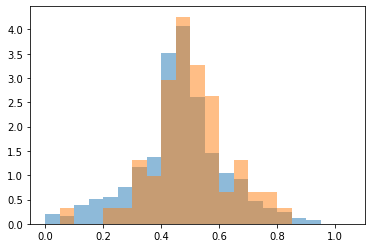

In [511]:
plt.hist(c1[(num_affected>1)], 
         bins=np.arange(0, 1.1, 0.05), density=True, alpha=0.5)
plt.hist(c1[(mat_changed | pat_changed) & hasneither & (num_affected>1)], 
         bins=np.arange(0, 1.1, 0.05), density=True, alpha=0.5)
plt.show()

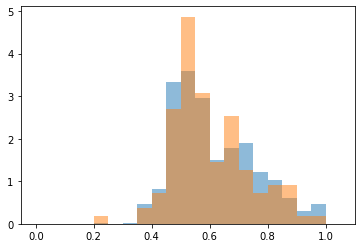

In [524]:
plt.hist(np.maximum(np.maximum(np.maximum(a1, b1), c1), d1), 
         bins=np.arange(0, 1.1, 0.05), density=True, alpha=0.5)
plt.hist(np.maximum(np.maximum(np.maximum(a1, b1), c1), d1)[(mat_changed | pat_changed) & hasneither], 
         bins=np.arange(0, 1.1, 0.05), density=True, alpha=0.5)
plt.show()

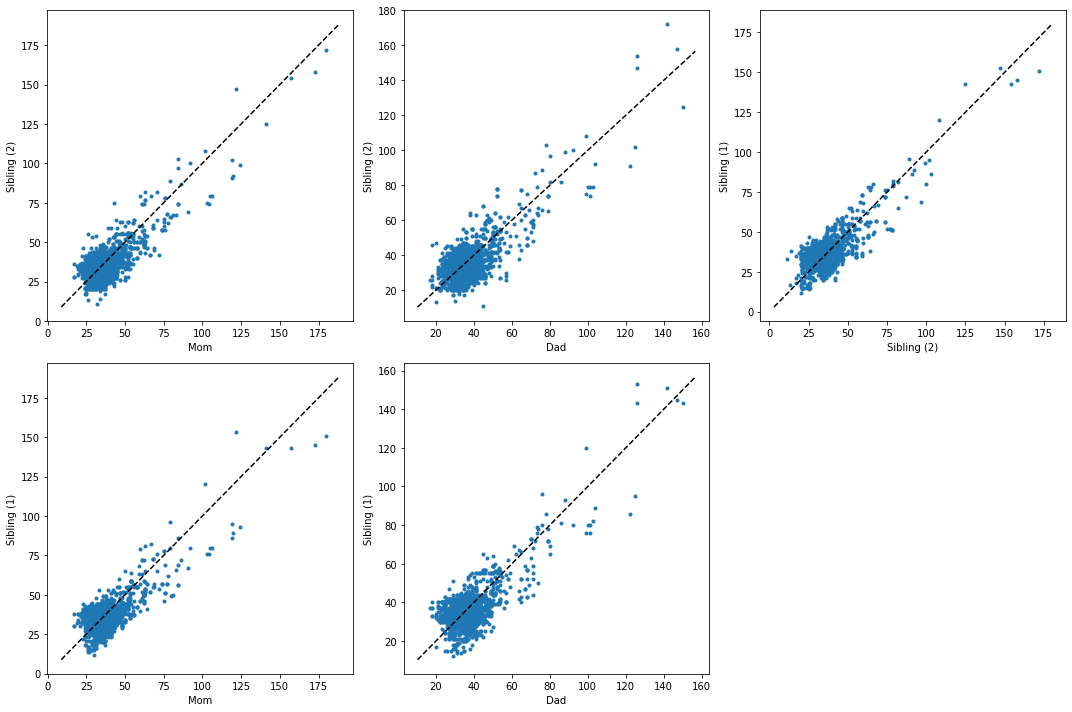

In [427]:
plt.figure(figsize=(15, 10))

sibpair = sibpairs_of_interest[index]

plt.subplot(2, 3, 1)
plt.scatter(np.sum(quad_ad[index, 0, :, :], axis=1), np.sum(quad_ad[index, 2, :, :], axis=1), marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Mom')
plt.ylabel('Sibling (%s)' % sample_to_affected[sibpair.sibling1])

plt.subplot(2, 3, 2)
plt.scatter(np.sum(quad_ad[index, 1, :, :], axis=1), np.sum(quad_ad[index, 2, :, :], axis=1), marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Dad')
plt.ylabel('Sibling (%s)' % sample_to_affected[sibpair.sibling1])

plt.subplot(2, 3, 3)
plt.scatter(np.sum(quad_ad[index, 2, :, :], axis=1), np.sum(quad_ad[index, 3, :, :], axis=1), marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

plt.xlabel('Sibling (%s)' % sample_to_affected[sibpair.sibling1])
plt.ylabel('Sibling (%s)' % sample_to_affected[sibpair.sibling2])

plt.subplot(2, 3, 4)
plt.scatter(np.sum(quad_ad[index, 0, :, :], axis=1), np.sum(quad_ad[index, 3, :, :], axis=1), marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Mom')
plt.ylabel('Sibling (%s)' % sample_to_affected[sibpair.sibling2])

plt.subplot(2, 3, 5)
plt.scatter(np.sum(quad_ad[index, 1, :, :], axis=1), np.sum(quad_ad[index, 3, :, :], axis=1), marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('Dad')
plt.ylabel('Sibling (%s)' % sample_to_affected[sibpair.sibling2])

plt.tight_layout()
plt.show()